# Определение возраста покупателей

# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:<br/>
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

# Инструкция по выполнению проекта
1. Проведите исследовательский анализ набора фотографий.
2. Подготовьте данные к обучению.
3. Обучите нейронную сеть и рассчитайте её качество.

## Исследовательский анализ данных

Нашей метрикой качества будет MAE.

**План выполнения проекта:**<br>
1. Провести исследовательский анализ набора данных в Jupyter.
2. Скачайте  тетрадь Jupyter Notebook.
3. Обучить модель в GPU-тренажёре и сохраните результат вывода модели на экран.
4. Объединить в финальной тетради Jupyter Notebook исследовательский анализ данных, код и вывод модели.
5. Проанализировать результат обучения модели.

**Описание данных**<br>
Данные взяты с сайта ChaLearn Looking at People.

В нашем распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age.

Извлечь данные из папки вам поможет новый метод ImageDataGenerator —flow_from_dataframe(dataframe, directory, ...).

**Задание 1**
**Исследовательский анализ данных:**
- Посмотреть на размер выборки.
- Построить график распределения возраста в выборке.
- Напечатать на экране 10–15 фотографий и посмотреть, как устроен датасет.
- Сделать выводы о том, как результаты исследования повлияют на обучение модели.

In [ ]:
import pandas as pd
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [ ]:
labels.shape

(7591, 2)

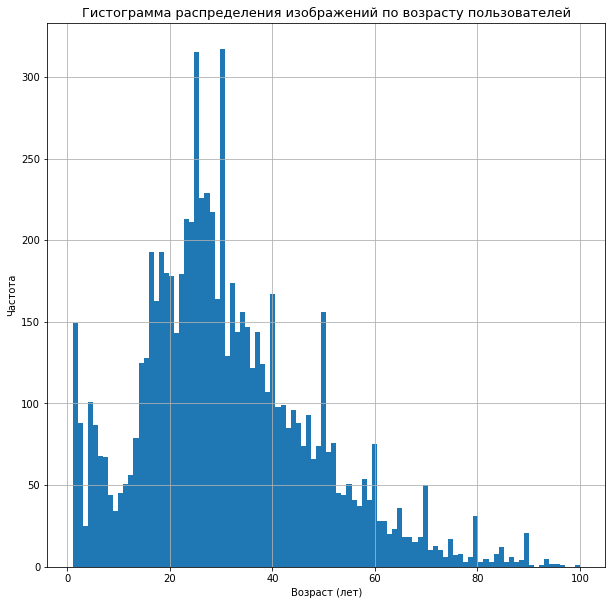

In [ ]:
#labels.hist(bins=100, figsize=(10,10));

plt.figure(figsize=(10,10))
plt.title("Гистограмма распределения изображений по возрасту пользователей", fontsize=13);
plt.hist(labels['real_age'], bins=100);
plt.xlabel("Возраст (лет)")
plt.ylabel("Частота")
plt.grid(True);


In [ ]:
labels.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [ ]:
labels.isna().sum()

file_name    0
real_age     0
dtype: int64

In [ ]:
def boxplot_real_age():
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Диаграмма размаха возраста пользователей на фото')
    ax.grid(True)
    ax.set_ylabel('Возраст пользователей (лет)')
    plt.boxplot(labels['real_age'] );

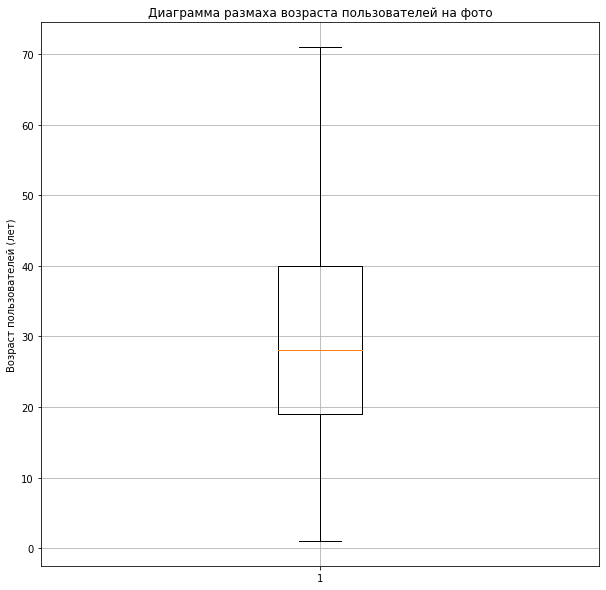

In [ ]:
boxplot_real_age()

In [ ]:
labels[labels['real_age']>72].count()

file_name    0
real_age     0
dtype: int64

In [ ]:
labels[(labels['real_age']>=20) & (labels['real_age']<=40)].count()

file_name    3806
real_age     3806
dtype: int64

In [ ]:
labels[(labels['real_age']>40) & (labels['real_age']<72)].count()

file_name    1727
real_age     1727
dtype: int64

In [ ]:
labels[labels['real_age']<20].count()

file_name    1876
real_age     1876
dtype: int64

In [ ]:
labels = labels.query("real_age<=71")

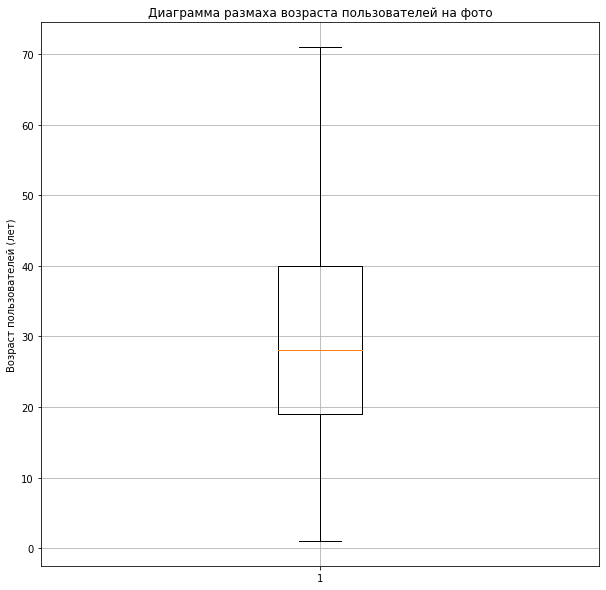

In [ ]:
boxplot_real_age()

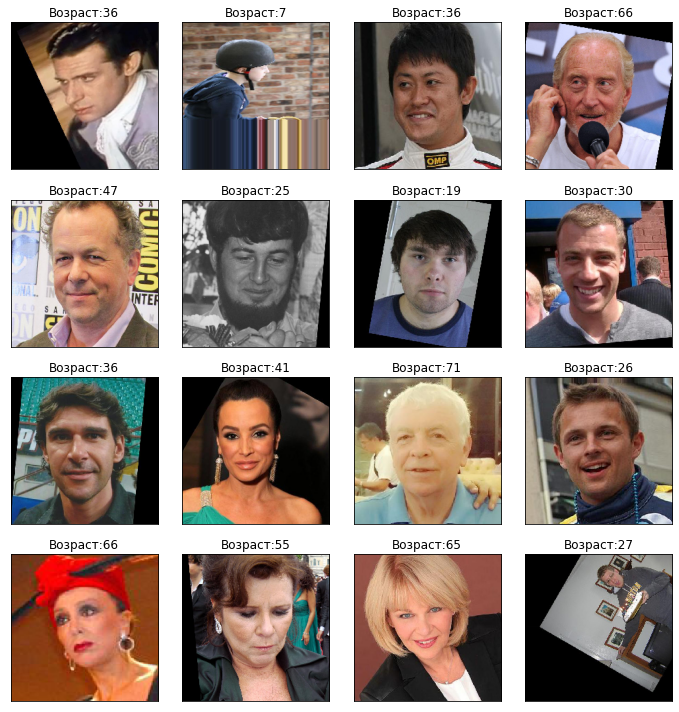

In [ ]:
features, target = next(train_gen_flow)

# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title("Возраст:" + str(target[i]))
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод:**
В датасете 7591 фотография. Таблица состоит из двух столбцов - имени файла с изображением и возраст пользователя на изображении. Пропусков нет.<br/>
Средний возраст на изображениях в датасете - 29 лет. Большая часть фото пользователей, возраст которых от 20 до 30 лет. Есть выбросы - возраст старше 72 лет. Таких значений немного - 136, удалим их, так как их мало и они не могут дать значимые предсказания.<br/>
Фото разные - цветные, не цветные, имеющие повороты, разного размера, в профиль, анфас, с разными эмоциями.

## Обучение модели

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1./255,
                                 horizontal_flip=True)

    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1./255)
    
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/20
356/356 - 54s - loss: 216.6369 - mae: 10.6094 - val_loss: 516.7135 - val_mae: 17.2947
Epoch 2/20
356/356 - 41s - loss: 89.5168 - mae: 7.2319 - val_loss: 203.3926 - val_mae: 10.2193
Epoch 3/20
356/356 - 42s - loss: 59.3420 - mae: 5.9038 - val_loss: 89.2606 - val_mae: 7.1400
Epoch 4/20
356/356 - 42s - loss: 45.2767 - mae: 5.1010 - val_loss: 85.1459 - val_mae: 6.9162
Epoch 5/20
356/356 - 52s - loss: 30.7897 - mae: 4.2548 - val_loss: 83.5782 - val_mae: 6.8190
Epoch 6/20
356/356 - 41s - loss: 22.8684 - mae: 3.6243 - val_loss: 73.9614 - val_mae: 6.6421
Epoch 7/20
356/356 - 42s - loss: 18.1130 - mae: 3.2271 - val_loss: 84.8613 - val_mae: 7.0773
Epoch 8/20
356/356 - 43s - loss: 15.3457 - mae: 2.9812 - val_loss: 72.3213 - val_mae: 6.4706
Epoch 9/20
356/356 - 43s - loss: 13.9830 - mae: 2.8219 - val_loss: 70.9985 - val_mae: 6.5003
Epoch 10/20
356/356 - 44s - loss: 13.6070 - mae: 2.7942 - val_loss: 74.1627 - val_mae: 6.3292
Epoch 11/20
356/356 - 44s - loss: 13.3446 - mae: 2.7815 - val_loss: 74.0854 - val_mae: 6.4998
Epoch 12/20
356/356 - 42s - loss: 13.3318 - mae: 2.7781 - val_loss: 71.0424 - val_mae: 6.3235
Epoch 13/20
356/356 - 41s - loss: 12.0068 - mae: 2.6409 - val_loss: 68.5332 - val_mae: 6.1912
Epoch 14/20
356/356 - 41s - loss: 12.1904 - mae: 2.6355 - val_loss: 69.3866 - val_mae: 6.2501
Epoch 15/20
356/356 - 42s - loss: 11.4002 - mae: 2.5697 - val_loss: 68.3215 - val_mae: 6.0584
Epoch 16/20
356/356 - 41s - loss: 10.7675 - mae: 2.4945 - val_loss: 70.2209 - val_mae: 6.1793
Epoch 17/20
356/356 - 41s - loss: 10.7822 - mae: 2.4550 - val_loss: 67.3349 - val_mae: 6.2705
Epoch 18/20
356/356 - 40s - loss: 10.2800 - mae: 2.4117 - val_loss: 68.7770 - val_mae: 6.1688
Epoch 19/20
356/356 - 41s - loss: 10.4329 - mae: 2.4543 - val_loss: 67.7657 - val_mae: 6.2001
Epoch 20/20
356/356 - 42s - loss: 9.6531 - mae: 2.3746 - val_loss: 63.1461 - val_mae: 5.9413
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 63.1461 - mae: 5.9413
Test MAE: 5.9413
```

 Цель достигнута. В статье о датасете, с которым мы работаем, значение MAE равно 5.4, поэтому получены достаточно хорошие результаты.


## Анализ обученной модели

1. Проведен исследовательский анализ набора фотографий. В ходе анализа выяснено следующее:
    - В датасете 7591 фотография. Таблица состоит из двух столбцов - имени файла с изображением и возраст пользователя на изображении. Пропусков нет. Средний возраст на изображениях в датасете - 29 лет. Большая часть фото пользователей, возраст которых от 20 до 30 лет.
    - Удалены выбросы - фото пользователей старше 72 лет.
    - Выяснилось, что излображения разные - цветные, не цветные, имеющие повороты, разного размера, в профиль, анфас, с разными эмоциями.

2. Данные подготовлены к обучению.

3. Нейронная сеть обучена и рассчитано её качество.
    Для обучения использована нейронная сеть ResNet50. Качество модели на тесте получилось  5.9413. Повысить качество удалось за счет увеличения эпох - взято 20. Аугментация с помощью horizontal_flip. Добавление других опций аугментации уменьшило точность модели.

Модель обучалась на исходной выборке. С датасетом не совсем понятно, так как модель обучала в отдельном тренажере, были написаны только функции, все остальное черный ящик.

Полученная модель  может использоваться для определения возраста человека по изображению. Что позволит с высокой точностью отнести покупателя к той или иной возрастной группе с целью анализа его покупок, рекомендаций товаров, которые могут его заинтересовать. А также позволит осуществлять контроль при продаже продукции, имеющей возрастные ограничения.